In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, classification_report
from sklearn.pipeline import Pipeline

In [2]:
df = pd.read_csv("data/online_shoppers_intention.csv")

display(df.info())
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12316 non-null  float64
 1   Administrative_Duration  12316 non-null  float64
 2   Informational            12316 non-null  float64
 3   Informational_Duration   12316 non-null  float64
 4   ProductRelated           12316 non-null  float64
 5   ProductRelated_Duration  12316 non-null  float64
 6   BounceRates              12316 non-null  float64
 7   ExitRates                12316 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

None

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0.0,0.0,0.0,0.0,1.0,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0.0,0.0,0.0,0.0,2.0,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0.0,-1.0,0.0,-1.0,1.0,-1.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0.0,0.0,0.0,0.0,2.0,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0.0,0.0,0.0,0.0,10.0,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


## Análisis de las Variables del Dataset de Google Analytics

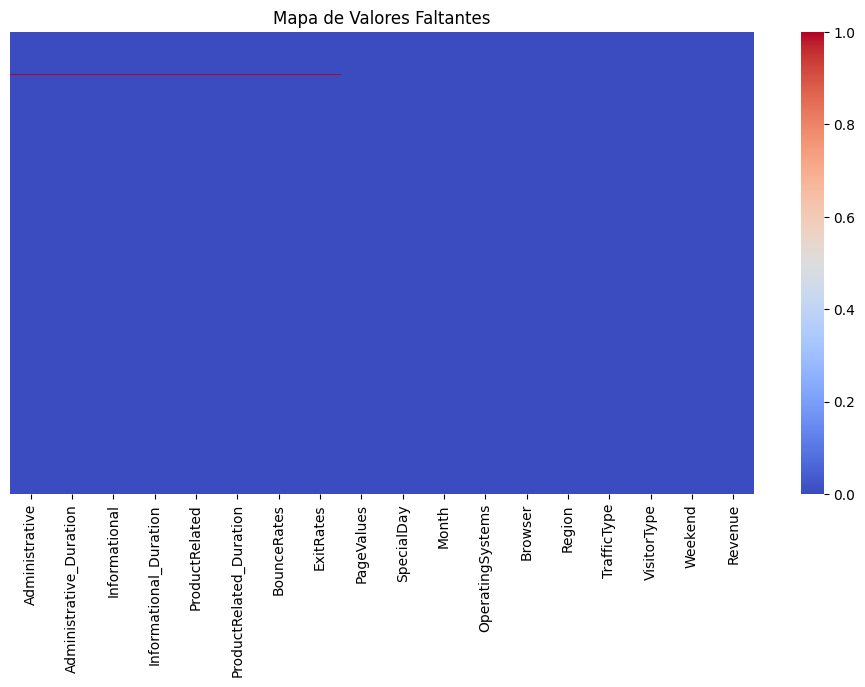

In [3]:
# Heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cmap='coolwarm', cbar=True, yticklabels=False)
plt.title("Mapa de Valores Faltantes")
plt.show()

El heatmap muestra que solo unas pocas filas presentan valores faltantes en algunas variables como Administrative, Administrative_Duration, Informational, Informational_Duration, y ProductRelated_Duration. 

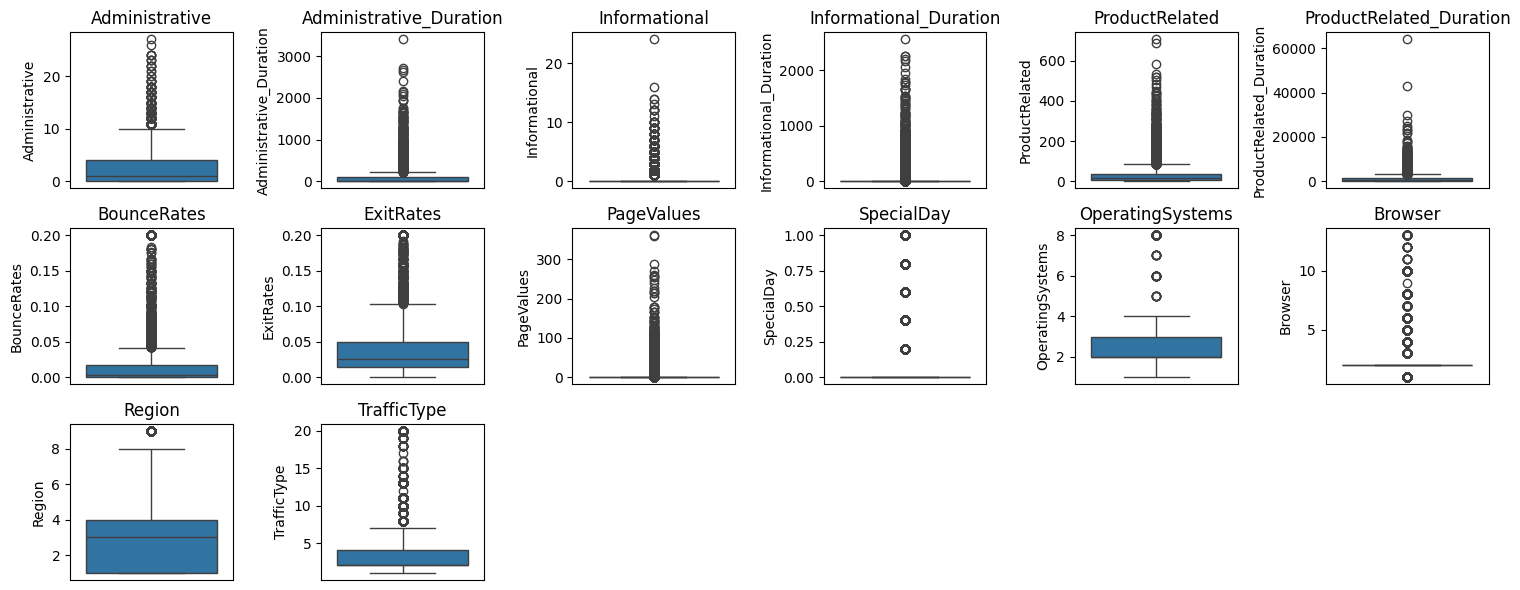

In [4]:
# Boxplots
num_cols = df.select_dtypes(include=['number']).columns

plt.figure(figsize=(15, 6))
for i, col in enumerate(num_cols, 1):
    plt.subplot(3, 6, i)
    sns.boxplot(y=df[col])
    plt.title(col)
    plt.xticks([])
plt.tight_layout()
plt.show()

Los boxplots evidencian que varias variables, como ProductRelated_Duration, presentan valores atípicos extremos. Esto sugiere que hay sesiones con tiempos de navegación mucho más largos que el promedio. En lugar de eliminarlos, optamos por estandarizarlos los datos, asegurando que los valores extremos no distorsionen el modelo sin perder información valiosa.

### Distribución de las Variables (Histogramas)

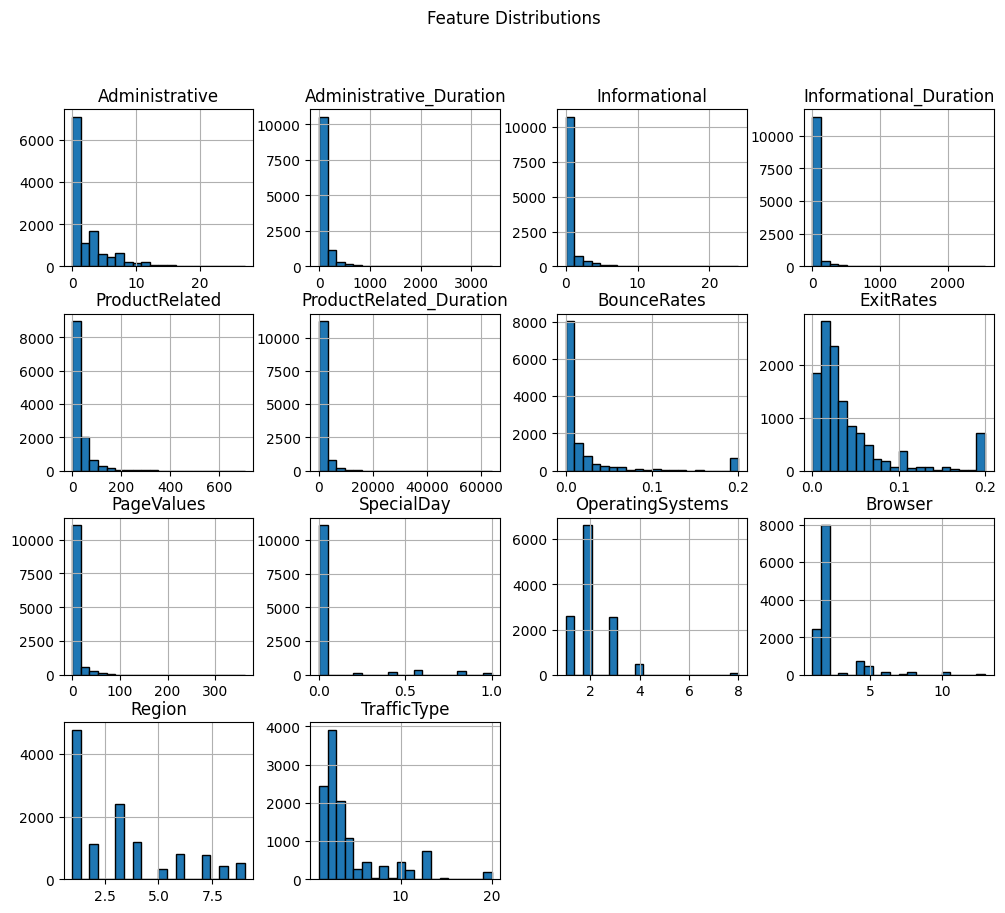

In [5]:
num_cols = df.select_dtypes(include=['number']).columns
df[num_cols].hist(figsize=(12, 10), bins=20, edgecolor='black')
plt.suptitle("Feature Distributions")
plt.show()

- Muchas variables presentan distribuciones sesgadas, como BounceRates, ExitRates y PageValues, donde la mayoría de los valores son cercanos a 0 y unos pocos casos tienen valores altos.

- Administrative, Informational y SpecialDay muestran que la mayoría de los usuarios no interactúan con estas secciones.

- PageValues parece tener un comportamiento bimodal, lo que sugiere diferencias claras entre usuarios que compran y los que no.

### Análisis de Valores Faltantes

In [6]:
df.shape

(12330, 18)

In [7]:
df_cleaned = df.dropna()

print(df_cleaned.isnull().sum())

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64


In [8]:
df_cleaned.shape

(12316, 18)

In [9]:
df.dropna(inplace=True)

In [10]:
label_enc = LabelEncoder()
df['Month'] = label_enc.fit_transform(df['Month'])
df['VisitorType'] = label_enc.fit_transform(df['VisitorType'])

### Justificación del Tratamiento de Variables Categóricas con get_dummies()

In [11]:
df = pd.get_dummies(df, columns=['Weekend'], drop_first=True)

In [12]:
X = df.drop(columns=['Revenue'])
y = df['Revenue']

In [13]:
correlation_threshold = 0.05

correlation_matrix = df.corr()
correlation_with_target = correlation_matrix["Revenue"].sort_values(ascending=False)

low_correlation_vars = correlation_with_target[abs(correlation_with_target) < correlation_threshold].index.tolist()

df_cleaned = df.drop(columns=low_correlation_vars)

df_cleaned.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,VisitorType,Revenue
0,0.0,0.0,0.0,0.0,1.0,0.000000,0.20,0.20,0.0,0.0,2,2,False
1,0.0,0.0,0.0,0.0,2.0,64.000000,0.00,0.10,0.0,0.0,2,2,False
2,0.0,-1.0,0.0,-1.0,1.0,-1.000000,0.20,0.20,0.0,0.0,2,2,False
3,0.0,0.0,0.0,0.0,2.0,2.666667,0.05,0.14,0.0,0.0,2,2,False
4,0.0,0.0,0.0,0.0,10.0,627.500000,0.02,0.05,0.0,0.0,2,2,False


In [14]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [16]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "Neural Network": MLPClassifier(max_iter=500)
}

best_models = {}

In [17]:
for model_name, model in models.items():
    pipe = Pipeline([("scaler", StandardScaler()), ("classifier", model)])
    param_grid = {}
    if model_name == "Random forest":
        param_grid = {"classifier__n_estimators": [50, 100, 200]}
    elif model_name == "Neural Network":
        param_grid = {"classifier__hidden_layer_sizes": [(50,), (100,)]}
    grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='roc_auc')
    grid_search.fit(X_train, y_train)
    best_models[model_name] = grid_search.best_estimator_

/home/codespace/.local/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/codespace/.local/lib/python3.1

In [18]:
results = {}
for model_name, model in best_models.items():
    y_pred = model.predict_proba(X_test)[:, 1]
    auc_score = roc_auc_score(y_test, y_pred)
    results[model_name] = auc_score
    print(f"{model_name} AUC: {auc_score:.4f}")

Logistic Regression AUC: 0.8872
Random Forest AUC: 0.9269
Neural Network AUC: 0.9059


In [19]:
best_model_name = max(results, key=results.get)
best_model = best_models[best_model_name]

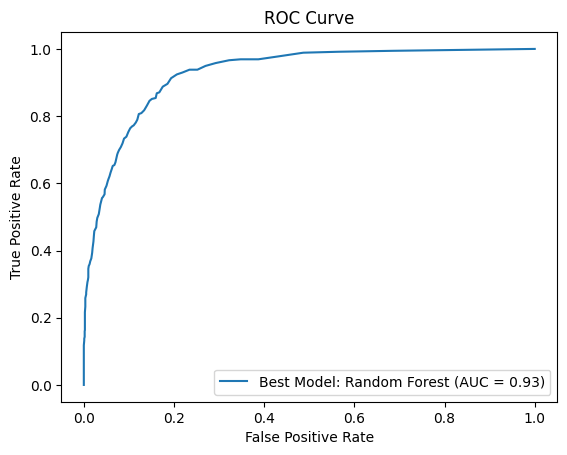

In [20]:
fpr, tpr, _ = roc_curve(y_test, best_model.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr, label=f'Best Model: {best_model_name} (AUC = {results[best_model_name]:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [21]:
fpr, tpr, thresholds = roc_curve(y_test, best_model.predict_proba(X_test)[:, 1])
youden_index = np.argmax(tpr - fpr)
best_threshold = thresholds[youden_index]
print(f"Optimal threshold: {best_threshold:.4f}")

Optimal threshold: 0.1400


In [22]:
final_predictions = (best_model.predict_proba(X_test)[:, 1] >= best_threshold).astype(int)
print(classification_report(y_test, final_predictions))

              precision    recall  f1-score   support

       False       0.98      0.81      0.89      2108
        True       0.44      0.91      0.60       356

    accuracy                           0.82      2464
   macro avg       0.71      0.86      0.74      2464
weighted avg       0.90      0.82      0.84      2464



### Justificación